In [1]:
import os
os.chdir("/nfs/homedirs/schwienb/project-4")


%load_ext autoreload
%autoreload 2

In [2]:
from src.models.pixelcnn import PixelCNN
# from src.models.pixelcnn2 import PixelCNN
from src.data.mnist import MNISTDataModule
from pytorch_lightning import Trainer
import torch
from tqdm import tqdm
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
experiment_name = "PixelCNN_MNIST_1.2"

In [7]:
mnistdata = MNISTDataModule()
mnistdata.prepare_data()
mnistdata.setup()

logger = TensorBoardLogger("lightning_logs", name=experiment_name)

early_stop_callback = EarlyStopping(
   monitor='avg_val_loss',
   min_delta=0.0000,
   patience=3,
   verbose=True,
)

model = PixelCNN()
model.to(device)
model.cuda()
trainer = Trainer(max_epochs=30, gpus=1, logger=logger, callbacks=[early_stop_callback])



EarlyStopping mode set to min for monitoring avg_val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [9]:
trainer.fit(model, mnistdata)

Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 1 M   


Traceback (most recent call last):
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the Lightni

1

In [12]:
trainer.save_checkpoint("models/" + experiment_name + ".ckpt")

In [8]:
model = model.load_from_checkpoint(checkpoint_path="models/"+ experiment_name +".ckpt").cuda()

In [9]:
test_dataloader = mnistdata.test_dataloader()

In [10]:
test = trainer.test(model, test_dataloaders=[test_dataloader], verbose=False)

Set SLURM handle signals.


/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [11]:
fashionmnistdata = FashionMNIST('data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
fashion_testdata = DataLoader(fashionmnistdata, batch_size=1, shuffle=False,  drop_last=True, pin_memory=True)
testfashion = trainer.test(model, test_dataloaders=[fashion_testdata], verbose=False)

Set SLURM handle signals.
/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [12]:
losses = torch.Tensor(test[1]['loss']).numpy()
fashionlosses = torch.Tensor(testfashion[1]['loss']).numpy()

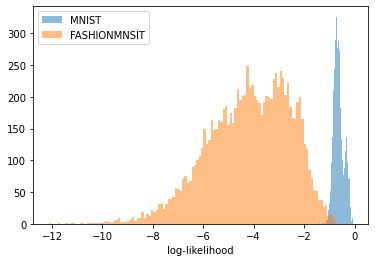

In [17]:
plt.hist(losses * -1, 100, alpha=0.5, label='MNIST')
plt.hist(fashionlosses * -1, 120, alpha=0.5, label='FASHIONMNSIT')
plt.legend(loc='upper left')
plt.xlabel('log-likelihood')
plt.show()

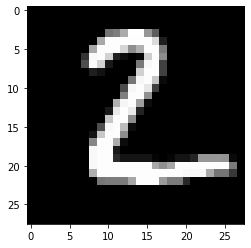

In [11]:
testdata = mnistdata.test_dataset
first = testdata[1][0]

plt.imshow(first.numpy()[0], cmap='gray')


In [25]:
model.eval()
res = model(first.unsqueeze(0).cuda())

In [26]:
img = res.detach().cpu().numpy()[0]
probs = torch.nn.Softmax()(res[0,:,:,:]).detach().cpu().numpy()

<ipython-input-26-4b77fa0eb7ef>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.Softmax()(res[0,:,:,:]).detach().cpu().numpy()


In [88]:
like = np.zeros((28,28))
for i in range(28):
    for j in range(28):
        like[i,j] = np.sum(img[:,i,j])

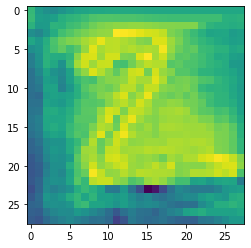

In [89]:
plt.imshow(like)

In [62]:
test[0]['test_loss']

0.6255863904953003

In [66]:
bpd = (test[0]['test_loss'] / (28 *28) ) / np.log(2)
bpd

0.0011511867132846891

In [59]:
like = np.zeros((28,28))
for i in range(28):
    for j in range(28):
        like[i,j] = np.argmax(res2[:,i,j])

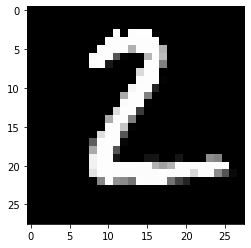

In [60]:
plt.imshow(like, cmap='gray')

In [33]:
sample = torch.Tensor(144, 1, 28, 28).cuda()
from torch.autograd import Variable
import torch.nn.functional as F
model.cuda()

PixelCNN(
  (blocks): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (13): BatchNorm2d(64, eps=1

In [34]:
sample.fill_(0)
model.train(False)
for i in range(28):
    for j in range(28):
        out = model(Variable(sample, volatile=True))
        probs = F.softmax(out[:, :, i, j]).data
        sample[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.


<ipython-input-34-cdbe7c3731aa>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  out = model(Variable(sample, volatile=True))
<ipython-input-34-cdbe7c3731aa>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


In [35]:
sample.size()

torch.Size([144, 1, 28, 28])

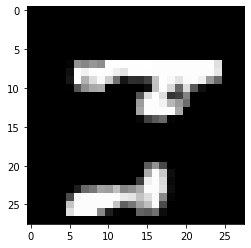

In [36]:
plt.imshow(sample.detach().cpu().numpy()[143][0], cmap='gray')

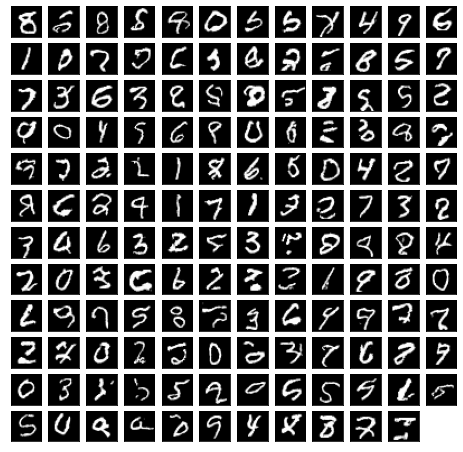

In [54]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))

columns = 12
rows = 12
for i in range(1, columns*rows +1):
    if i < 144:
        fig.add_subplot(rows, columns, i)
        plt.imshow(sample.detach().cpu().numpy()[i][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
plt.show()
